## Slow Feature Analysis
#### Exercise 1: Slow Feature Analysis on two independent signals

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy as sp
import seaborn as sns
sns.set(palette='Set2')

Write a function that generates a random signal of length T (number of samples) that has an average frequency spectrum corresponding to PSD(k)=exp(-||k||^2 / (2 epsilon)):

In [18]:
def low_signal(rand_signal, epsilon, sample_period):
    
    fft_rand_signal = np.fft.fft( rand_signal )
    frq_rand_signal = np.fft.fftfreq( rand_signal.size, sample_period )
    
    filter_low = np.sqrt(np.exp(- frq_rand_signal**2 / (2*epsilon)))
    filter_low = filter_low / np.sum(filter_low)
   
    filter_fft_rand_signal = fft_rand_signal*filter_low
    filter_rand_signal = np.real(np.fft.ifft( filter_fft_rand_signal ))
    return filter_rand_signal;


Use the function from the task above to generate two independent 1D-signals:

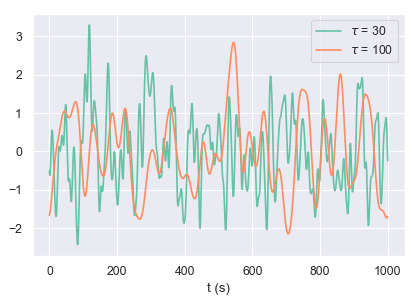

In [19]:
tau1 = 30
tau2 = 100
e1 = 1/(tau1**2)
e2 = 1/(tau2**2)

T = 1000 #number of samples
dt = 1
t = np.linspace(0, T*dt, T) #time axis

s_rand1 = np.random.random(T);
s_rand2 = np.random.random(T);

k = np.fft.fftfreq(T, d=dt) #fequency axis

s1 = low_signal(s_rand1, e1, dt)
s2 = low_signal(s_rand2, e2, dt)

x1 = (s1 - np.mean(s1))/(np.std(s1))
x2 = (s2 - np.mean(s2))/(np.std(s2))

plt.figure(dpi=80)
plt.plot(t, x1, label=r'$\tau$ = {}'.format(tau1))
plt.plot(t, x2, label=r'$\tau$ = {}'.format(tau2))
plt.xlabel('t (s)')
plt.legend()
plt.show()

We will now perform linear SFA to see whether we can generate a slow signal by linearly combining both signals. Compute the joint covariance matrix of both signals  as well as the matrix of second moments of the temporal derivative. Next, to perform SFA, we need to solve the Generalised Eigenvalue Problem of both matrices.

In [7]:
X = np.vstack((x1, x2))
C = np.cov(X)
dX = np.diff(X)/dt
dC = np.dot(dX, dX.T)/(T-1)
w_comp, v = sp.linalg.eig(dC, C)
w = w_comp.real

The eigenvectors determine how the input signals are mixed by the SFA to generate the new (slow) signals. What kind of mixture do you ideally expect given how the data was generated? What does the empirical mixture look like, judging from the extracted eigenvectors?

Repeat task 3 with different signal sample sizes and store the resulting normalised eigenvectors. Plot the four individual components of the eigenvectors against the number of samples.

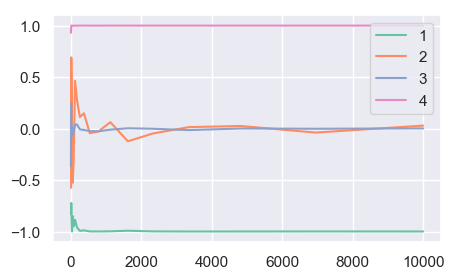

In [24]:
T = np.logspace(1, 4, 20, dtype='int')

def sfa (size):
    
    dt = 1
    
    #generate two signals filtered by a lpf
    s1 = low_signal(np.random.random(size), e1, dt)
    s2 = low_signal(np.random.random(size), e2, dt)
    
    #normalize the signals
    x1 = (s1 - np.mean(s1))/(np.std(s1))
    x2 = (s2 - np.mean(s2))/(np.std(s2))
    
    
    X = np.vstack((x1, x2)) 
    C = np.cov(X)
    dX = np.diff(X)/dt
    dC = np.dot(dX, dX.T)/(size-1)
    w, v = sp.linalg.eig(dC, C)
    return v;

V = []; #eigenvector matrix
for size in T:
    V.append(sfa(size));

V = np.array(V)

v1 = np.array([V[i][0][0] for i in range(0, len(T))])
v2 = np.array([V[i][1][0] for i in range(0, len(T))])
v3 = np.array([V[i][0][1] for i in range(0, len(T))])
v4 = np.array([V[i][1][1] for i in range(0, len(T))])

plt.figure(figsize=(5, 3), dpi=100)
plt.plot(T, v1, label='1')
plt.plot(T, v2, label='2')
plt.plot(T, v3, label='3')
plt.plot(T, v4, label='4')
plt.legend()
plt.show()

How do the eigenvalues depend on the $\tau$'s that you chose?

In [20]:
print(w[0])
print(w[1])

0.043588034106339116
0.004472074743018432
